## INTRODUCTION

We will be using <a href="https://archive.ics.uci.edu/ml/datasets/Bank+Marketing" target="_blank">Bank marketing</a> dataset from UCI Machine Learning repository to predict if a client will subscribe a term deposit from direct marketing campaigns of a Portuguese banking institution. A term deposit is a fixed-term investment that includes the deposit of money into an account at a financial institution. In this dataset, there are three categories of attributes used:

1. Bank client data (age, education, housing, loan details etc)
2. Data related to last contact of the current campaign such as contact day, duration etc.
3. Other attributes such as number of previous contacts and their outcomes.

More details of attributes can be found in the website.


In [1]:
# importing libraries
import pandas as pd
import numpy as np                     # For mathematical calculations
import seaborn as sns                  # For visualizations
import matplotlib.pyplot as plt        # For plotting graphs
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit                  # For stratified splitting of dataset
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV   # For model fitting
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, roc_auc_score                   # For calculatin score
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the data
data = pd.read_csv("bank-additional-full.csv",sep=';')

## EXPLORING THE DATA

Let's start by checking the shape of dataset and its attributes. 

In [3]:
data.shape

(41188, 21)

In [4]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

So we have 20 independent variables and 1 dependent variable y, which we will predict using regression model.

In [5]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

We see that there are variables of float, int and object types, which will need to be transformed before building model. Let's now see how the first few rows of the dataset look like.

In [6]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


The value 999 in pdays is just a huge number to indicate that the client has not been previously contacted. Furthermore, the duration column will be dropped during model building as it cannot be known before contacting a client and it is highly correlated with deposit. Hence the model will be more realistic.

Let's now check for missing values.

In [7]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no missing values in the set. 

## UNIVARIATE ANALYSIS

Let us see the distributions of various variables. Before that we'll look at some statistics of continuous variables.

In [8]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Let's see the ratio of people who have subscribed deposit to those who haven't. 

In [9]:
data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [10]:
data['y'].value_counts(normalize=True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

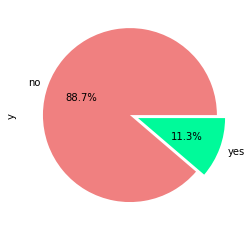

In [11]:
data['y'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colors=["#F08080", "#00FA9A"])

We see that 88.7% or 36548 people have not subscribed. This is a highly imbalanced dataset.

Let us see the distribution of age variable.

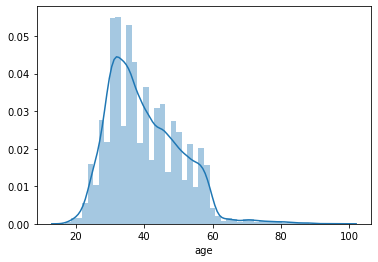

In [12]:
sns.distplot(data['age'])

Let us have a quick look at the distributions of categorical variables.

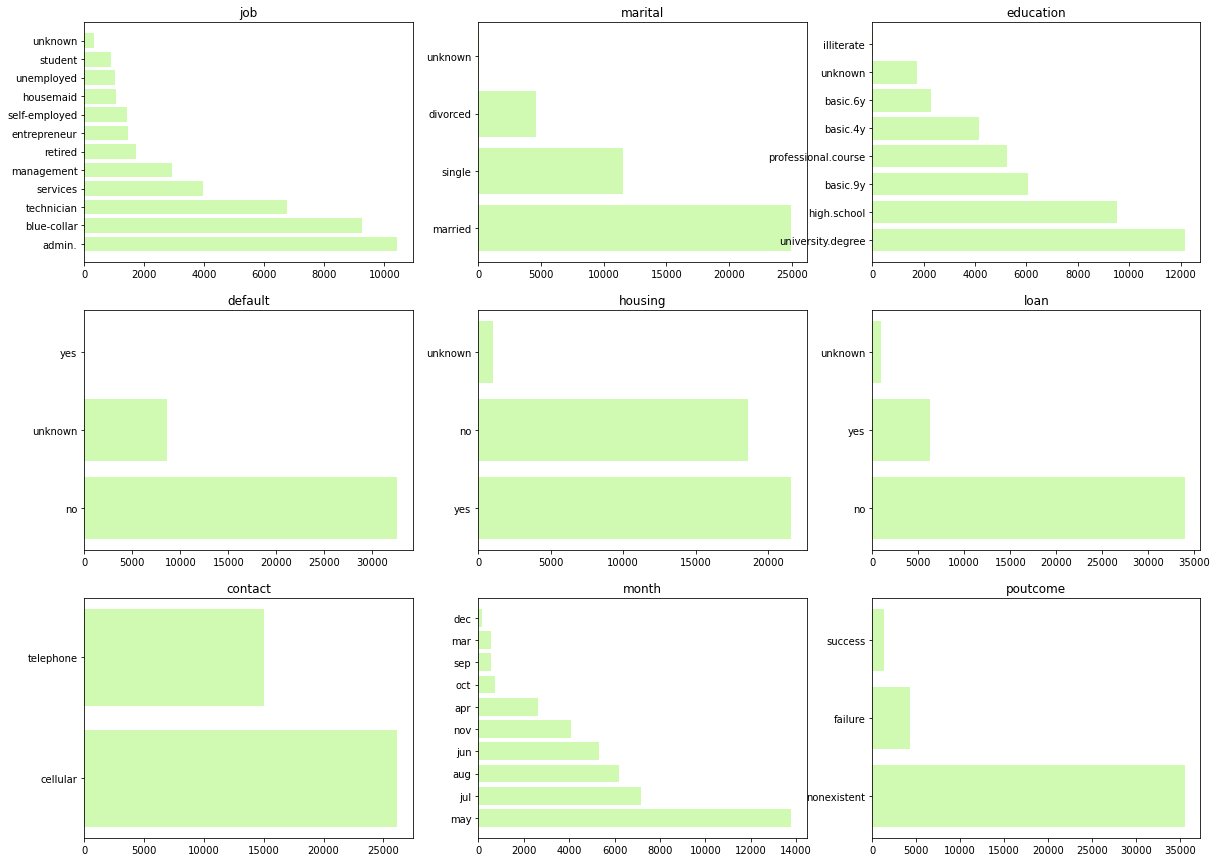

In [13]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

for i in range(3):
    for j in range(3):
        value_counts= data[cat_columns[3*i+j]].value_counts()
        x_pos = np.arange(0, len(value_counts))
        axs[i,j].barh(x_pos,value_counts.values,tick_label = value_counts.index,color=['#D0F9B1'])
        axs[i,j].set_title(cat_columns[3*i+j])

We can summarize the following from univariate analysis:

1. Most people(89%) have not subscribed to deposit.
2. Most contacted age groups lie between 20-60.
3. Most contacted people have admin, blue-collar or technical jobs whereas students are the least contacted which is natural as students don't usually take term deposits.
4. Most of the population is married, has university degree, has no default or loans.
5. People with and without housing loans don't have a huge gap.
6. May-Aug are popular months for campaign and winter months are least popular.
7. Cellular contact is used more than telephone and the outcomes of previous campaigns are mostly non-existent, and failures ratio is more than success.

## BIVARIATE ANALYSIS

Let's now see how variables are correlated to y(dependent variable). We will look at categorical variables first.

*Green represents 'Yes' and purple represents 'No'.

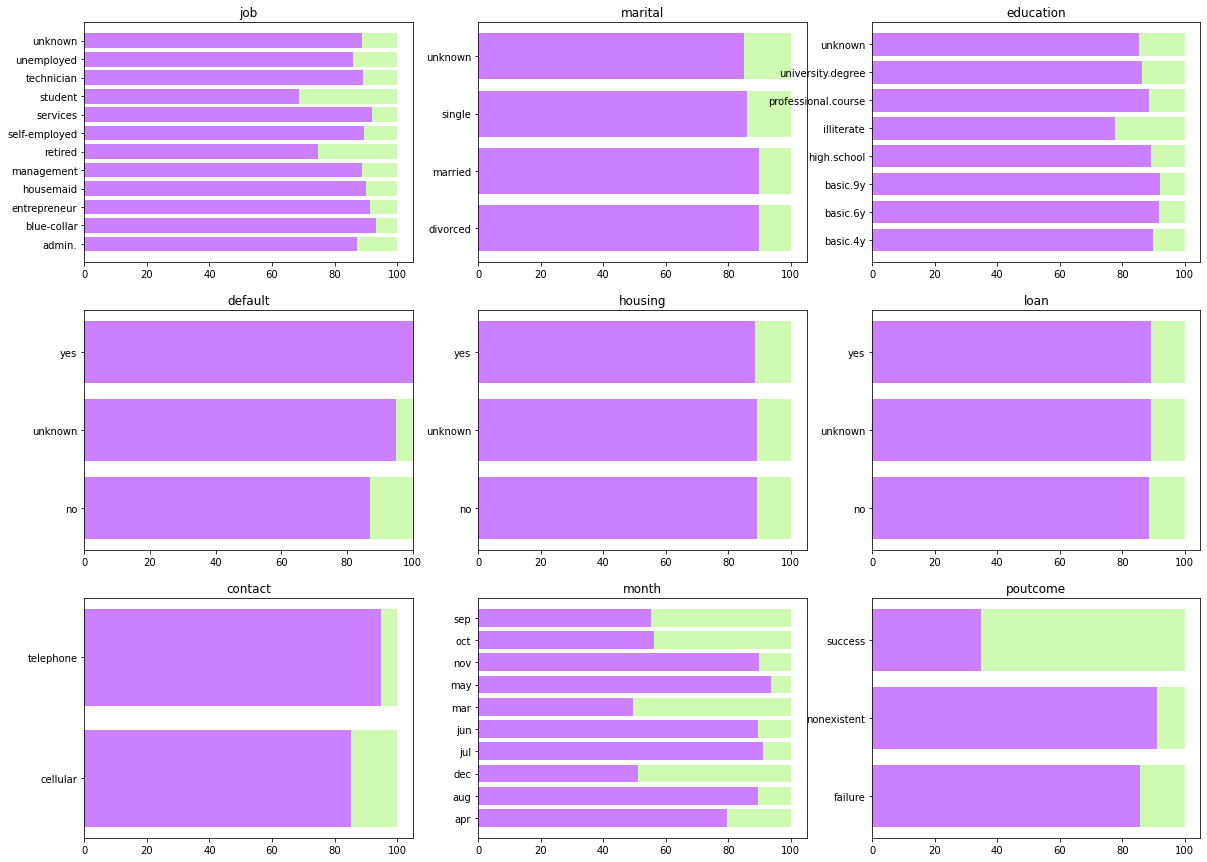

In [14]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

for i in range(3):
    for j in range(3):
        df= pd.crosstab(data[cat_columns[3*i+j]],data['y'],normalize=True)
        df['sum']=df['no']+df['yes']
        df['no']=df['no']*100/df['sum']
        df['yes']=df['yes']*100/df['sum']
        df.drop(columns='sum',inplace=True)
        x_pos = np.arange(0, len(value_counts))
        p1=axs[i,j].barh(x_pos,df['no'].values,tick_label=df.index,color=['#cc80ff'])
        p2=axs[i,j].barh(x_pos,df['yes'].values,left=df['no'].values,tick_label = df.index,color=['#D0F9B1'])
        axs[i,j].set_title(cat_columns[3*i+j])    

We can summarize the following:

1. We surprisingly see that students and retired people have higher percentage of subscription, however it could be because of low sample size.
2. Illiterate people have higher chance of subscription than people with higher education.
3. People with default history and those who didn't subscribe during last campaign have very low chance of subscription.
4. People with and without loans have similiar subscription chance.
5. Calls made during winter and later in March and using cellular contact are more succesful than other months.

Now let us see the correlation of continuous variables. For that, we need to convert dependent variable into numeric data.

In [16]:
data['y'].replace('no', 0,inplace=True)
data['y'].replace('yes', 1,inplace=True)

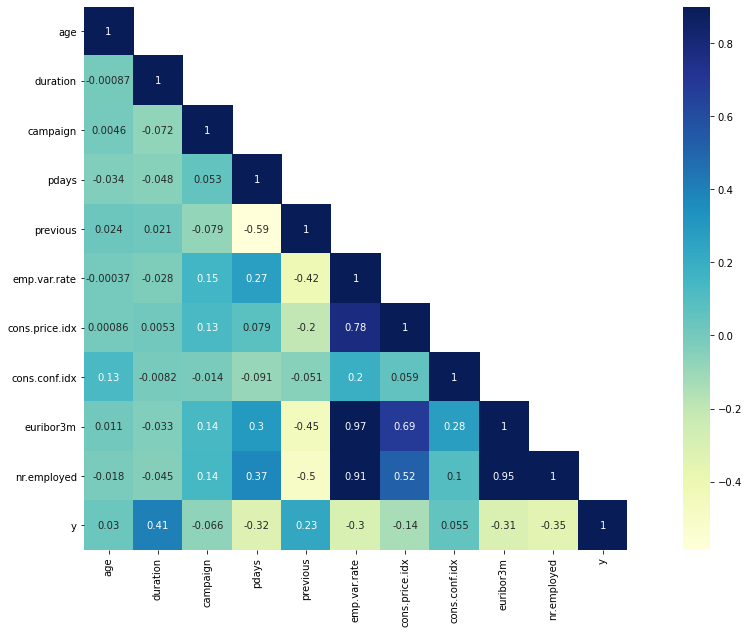

In [17]:
corr = data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr, mask=mask,vmax=.9, square=True,annot=True, cmap="YlGnBu")

We can see that age, call duration and previous campaigns are relatively more correlated with y.

## MODEL BUILDING

Let's start by removing duration column for a realistic model. 


In [18]:
data.drop(columns='duration',inplace= True)

# features for prediction
feature_cols=data.columns[:-1]        
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


Let us now convert categorical variables to numeric by creating dummy variables. Then we will split our dataset into test and training set ensuring that the ratios of subscribed population remain approximately same in both. We will use stratified split for that.

In [19]:
#creating dummy variables
data_x= data[feature_cols]
data_x=pd.get_dummies(data_x)

#creating split
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data_x, data.y))

# Create the dataframes after split
X_train = data_x.loc[train_idx,:]
y_train = data.y[train_idx]

X_test  = data_x.loc[test_idx,:]
y_test  = data.y[test_idx]
print("Shape of training set", X_train.shape)
print("SHape of test set", X_test.shape)

Shape of training set (28831, 62)
SHape of test set (12357, 62)


Let us check whether training and test set have equal ratios of subscribed population.

In [20]:
y_train.value_counts(normalize=True)

0    0.887343
1    0.112657
Name: y, dtype: float64

In [21]:
y_test.value_counts(normalize=True)

0    0.887351
1    0.112649
Name: y, dtype: float64

The ratios are same. Now we will:

1. Fit a logistic regression model without reguralization and without cross validation.
2. Fit a model by tuning hyperparameters and use regularization.

In [22]:
# Standard logistic regression
lr = LogisticRegression().fit(X_train, y_train)

# Logistic regression using cross validation
lr_CV = LogisticRegressionCV(scoring='roc_auc').fit(X_train,y_train)

Let us now compare what classes and probabilities each of these models have predited.

In [23]:
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'lr_CV']
coeff_models = [lr, lr_CV]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test)[:,1], name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)


In [24]:
#Predictions for both models
y_pred.head()

,lr,lr_CV
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1


In [25]:
#Probabilities of y=1 for both models
y_prob.head()

,lr,lr_CV
0,0.049058,0.059108
1,0.033030,0.034817
2,0.050605,0.056327
3,0.034052,0.032045
4,0.745939,0.725206


The models seem to have predicted similar values. Now let us check the following scores for the models to get a better comparison:

1. Accuracy
2. Precision
3. Recall
4. F-score
5. AUC

In [26]:
metrics = list()

for lab in coeff_labels:

    # Preciision, recall, f-score 
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(y_test, y_prob[lab],average='weighted')
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [27]:
metrics

,lr,lr_CV
precision,0.883283,0.887221
recall,0.900380,0.900866
fscore,0.875975,0.873072
accuracy,0.900380,0.900866
auc,0.788866,0.794396


Now let us check the cross validation scores of these models to get a better idea of theri generalization.

In [28]:
from sklearn.model_selection import cross_val_score

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, scoring='roc_auc')
log_reg_mean = log_scores.mean()

#Logistic Regression with cross validation
log_cv = LogisticRegressionCV()
scores_cv = cross_val_score(log_cv, X_train, y_train, scoring='roc_auc')
log_cv_mean = scores_cv.mean()

In [29]:
print("Cross val score for logistic Regression", log_reg_mean)
print("Cross val score for regression with cross validation", log_cv_mean)

Cross val score for logistic Regression 0.7740397332094405
Cross val score for regression with cross validation 0.7813687997295482


We see that after tuning hyperparameters, we get a better performance, which is evident from AUC score. In terms of generalization also, second model has a better cross-val score which means it generalizes well to new data.

Let us now see the contribution of features in prediction.

Feature: age Score: -0.00029427288631168587
Feature: campaign Score: -0.025182469394904497
Feature: pdays Score: -0.0013093968908684153
Feature: previous Score: -0.08787530414920627
Feature: emp.var.rate Score: -0.13709663997503113
Feature: cons.price.idx Score: 0.38640343737799127
Feature: cons.conf.idx Score: 0.04364563704559351
Feature: euribor3m Score: -0.17685606750603655
Feature: nr.employed Score: -0.006763805450201432
Feature: job_admin. Score: 0.04253411606749577
Feature: job_blue-collar Score: -0.08233718837429353
Feature: job_entrepreneur Score: -0.004887077542314043
Feature: job_housemaid Score: -0.0035567528554168726
Feature: job_management Score: 0.0016311850527041428
Feature: job_retired Score: 0.04429671555273018
Feature: job_self-employed Score: -0.0016626446610302184
Feature: job_services Score: -0.03063656196857701
Feature: job_student Score: 0.026047498519001202
Feature: job_technician Score: 0.008630286552844518
Feature: job_unemployed Score: 0.0029268802633918745


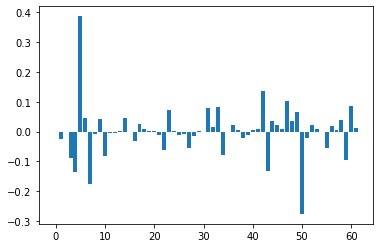

In [30]:
importance = lr.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print("Feature:",data_x.columns[i], "Score:", v)
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

We see that month, contact type, consumer price index and euribor3m have most contribution. 

Now, based on our analysis, we can try out the following steps next:

1. Focus on contacting during the months of May- Aug as it had the highest ratio of contacts as well as highest subscription rate.
2. Although the sample of retired people and students is less, it had a higher subscription rate, so it could be given a fair chance.
3. People with default or housing loan can be contacted less.